# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
df = pd.read_csv('AA_mintafeladat_converted.csv')


In [4]:
status_mapping = {
    'Aktív': 'active',
    'Aktív vendéghallgató': 'active',
    'Felvett': 'active',
    'Nem beszámító aktív': 'active',
    'Diplomát szerzett': 'graduated',
    'Sikeres záróvizsga': 'graduated',
    'Részismeretes(végzett)': 'graduated',
    'Záróvizsgát tett': 'graduated',
    'Abszolvált': 'graduated',
    'Passzív': 'at_risk',
    'Sikertelen záróvizsga': 'at_risk',
    'Még nem meghatározott': 'at_risk',
    'Saját kérésre törölve': 'dropped_out',
    'Törölt': 'dropped_out',
    'Bejelentés nélkül távozott': 'dropped_out',
    'Elhunyt': 'dropped_out',
    'Tagozat váltó': 'transferred',
    'Szakváltoztató': 'transferred',
    'Képzés váltó': 'transferred',
    'Intézményváltoztató': 'transferred',
    'Átsorolva más jelű tantervbe': 'transferred'
}
df['churn_target'] = (df['study_status'] == 'dropped_out').astype(int)

In [5]:
state_funded = ["Államilag támogatott", "Államilag finanszírozott", "Állami ösztöndíjas", "Miniszteri ösztöndíjas",
"Állami részösztöndíjas", "Államilag finanszírozott (képzési időn túli)", "A1 kategóriás külföldi ösztöndíjas", "B külf. külső tám. ösztöndíj",
"C kategóriás külföldi ösztöndíjas", "Államilag támogatott (képzési időn túli)", "Költségtérítés mentes (GYES...)", "Államilag finanszírozott túllépő",
"Államilag támogatott (vendéghallgató)", "Költségtérítés mentes", "Normatív támogatással A3 HTM", "A3R Részképzős HTM normatív támogatással"]
df['is_state_funded'] = (df['financial_status'].isin(state_funded)).astype(int)

df = df.groupby(['Key', 'modul_code', 'study_status', 'active_semesters']).agg({
    'start_of_study': 'first',
    'day_or_night': 'first', 
    'level_of_degree': 'first',
    'is_state_funded': 'first',
    'sex': 'first',
    'date_of_birth': 'first',
    'post_code': 'first',
    'taken_credit': 'sum',
    'cum_taken_credit': 'max',
    'comp_credits': 'sum', 
    'cum_comp_credits': 'max',
    'avg': 'mean',
    'cumulated_avg': 'last',
    'semester_num': 'count',  
    'academic_year': 'nunique',
    'churn_target': 'first'  
}).reset_index()

In [6]:
# Hungarian columns for analysis - nicer names
column_mapping = {
    'Key': 'student_id',
    'start_of_study': 'start_date',
    'modul_code': 'program_code', 
    'study_status': 'status',  # KépzésStátusz
    'day_or_night': 'study_mode',
    'level_of_degree': 'degree_level',
    'financial_status': 'funding_type',
    'semester_status': 'semester_status',
    'sex': 'gender',
    'date_of_birth': 'birth_date',
    'post_code': 'postal_code',
    'semester_num': 'semester_number',
    'active_semesters': 'active_semesters',
    'taken_credit': 'credits_taken',
    'cum_taken_credit': 'cumulative_credits',
    'comp_credits': 'completed_credits',
    'cum_comp_credits': 'cumulative_completed',
    'avg': 'gpa',
    'cumulated_avg': 'cumulative_gpa',
}

#  copy for analysis
df_analysis = df.copy()
df_analysis = df_analysis.rename(columns=column_mapping)

print("UNIVERSITY STUDENT DATA")
print(f"Dataset: {df_analysis.shape[0]:,} records, {df_analysis.shape[1]} columns")
print(f"Unique students: {df_analysis['student_id'].nunique():,}")
print(f"Date range: {df_analysis['academic_year'].min()} to {df_analysis['academic_year'].max()}")


UNIVERSITY STUDENT DATA
Dataset: 14,583 records, 20 columns
Unique students: 12,971
Date range: 1 to 9


Text(0, 0.5, 'Number of Students')

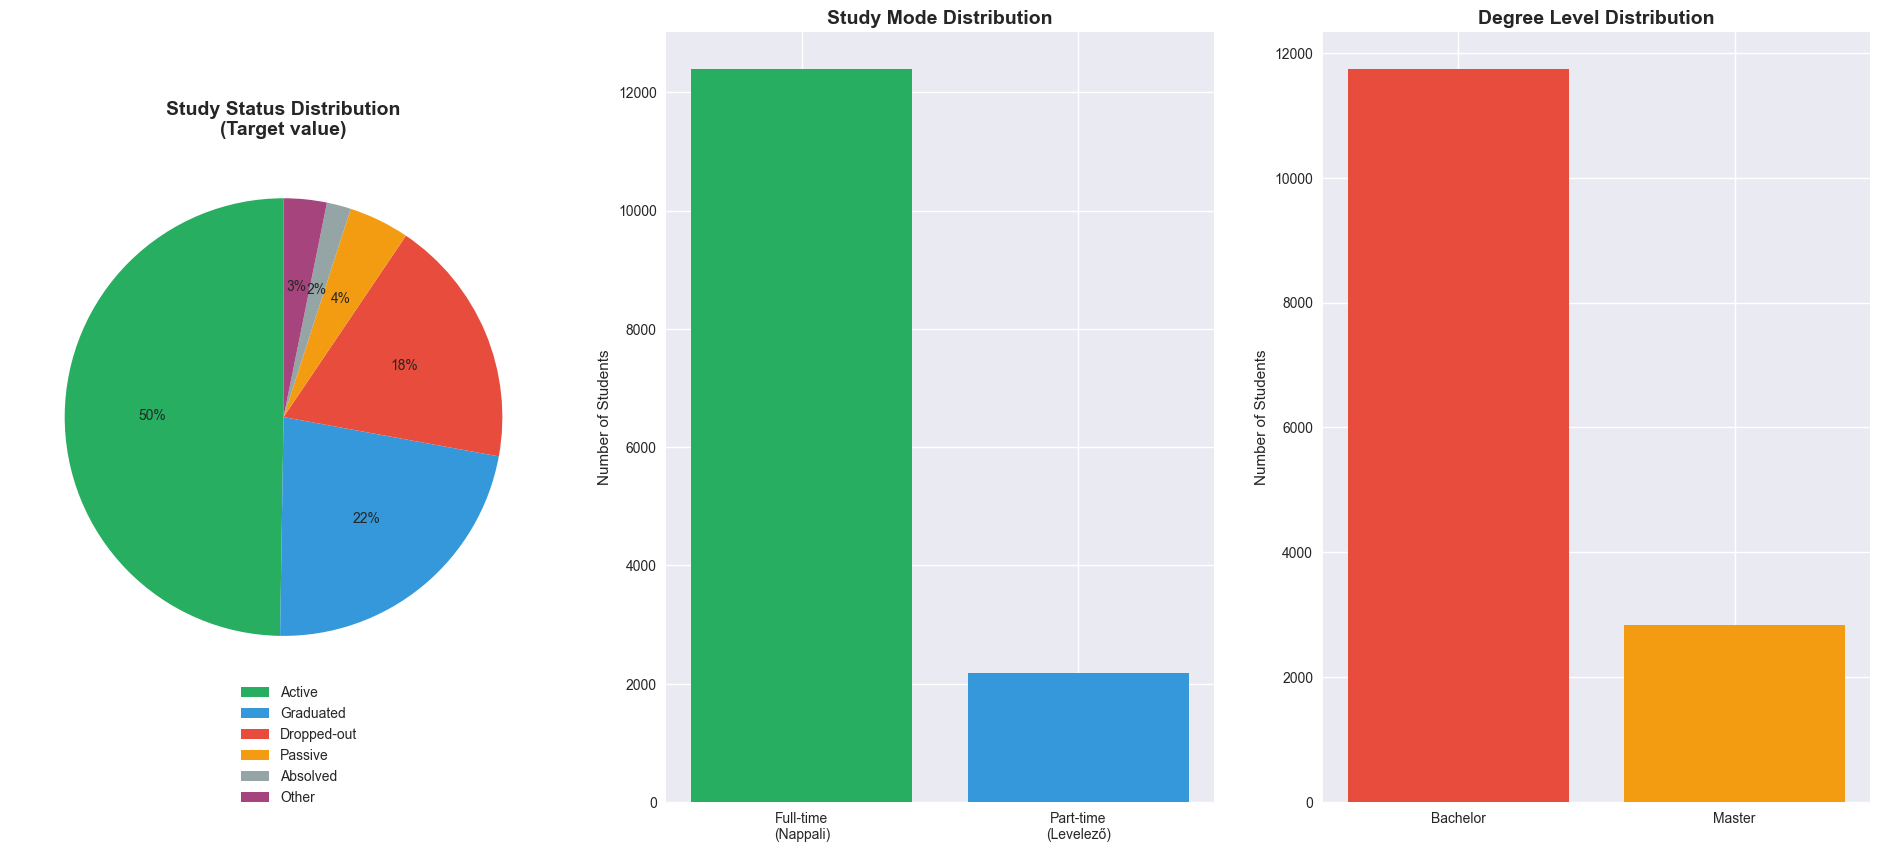

In [13]:
fig = plt.figure(figsize=(24, 10))

status_counts = df_analysis['status'].value_counts()

threshold = 0.015 * status_counts.sum()

# Split into major and minor categories
major_statuses = status_counts[status_counts >= threshold]
minor_statuses = status_counts[status_counts < threshold]

# minor statuses into "Other"
status_combined = major_statuses.copy()
status_combined['Other'] = minor_statuses.sum()

plt.subplot(1, 3, 1)
colors = ['#27ae60', '#3498db', '#e74c3c', '#f39c12', '#95a5a6', "#a6447d"] 
wedges, texts, autotexts = plt.pie(status_combined.values,labels=None,autopct='%1.0f%%',colors=colors[:len(status_combined)],startangle=90)

custom_labels = ['Active', 'Graduated', 'Dropped-out', 'Passive', 'Absolved', 'Other']
plt.title('Study Status Distribution\n(Target value)', fontsize=14, fontweight='bold')
plt.legend(custom_labels, loc='center left', bbox_to_anchor=(0.4, -0.1))



# Study Mode Distribution
plt.subplot(1, 3, 2)
study_mode_counts = df_analysis['study_mode'].value_counts()
plt.bar(range(len(study_mode_counts)), study_mode_counts.values, color=['#27ae60','#3498db'])
plt.title('Study Mode Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(len(study_mode_counts)), ['Full-time\n(Nappali)', 'Part-time\n(Levelező)'])
plt.ylabel('Number of Students')



# Degree Level Distribution
plt.subplot(1, 3, 3)
degree_counts = df_analysis['degree_level'].value_counts()
plt.bar(range(len(degree_counts)), degree_counts.values, color=['#e74c3c', '#f39c12'])
plt.title('Degree Level Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(len(degree_counts)), ['Bachelor', 'Master'])
plt.ylabel('Number of Students')

#

In [8]:
df_analysis

,student_id,program_code,status,active_semesters,start_date,study_mode,degree_level,is_state_funded,gender,birth_date,postal_code,credits_taken,cumulative_credits,completed_credits,cumulative_completed,gpa,cumulative_gpa,semester_number,academic_year,churn_target
0,1,ETNEMBSC,Aktív,7.0000,2010.09.10,Nappali,alapképzés (BA/BSc),1,Nő,1991-12-01,1126,206.0000,206.0000,206.0000,206.0000,4.3200,4.2900,7,4,0
1,2,ETNEMBSC,Diplomát szerzett,7.0000,2008.09.12,Nappali,alapképzés (BA/BSc),0,Nő,1990-02-01,4031,201.0000,201.0000,195.0000,195.0000,3.7200,3.6700,7,4,0
2,3,3MLKERT,Törölt,6.0000,2008.09.09,Levelező,mesterképzés (MA/MSc),0,Férfi,1983-04-01,3036,184.0000,184.0000,99.0000,99.0000,1.9490,3.7000,10,5,0
3,4,7BNKOMM,Aktív,1.0000,2013.09.05,Nappali,alapképzés (BA/BSc),0,Férfi,1994-08-01,9400,31.0000,31.0000,24.0000,24.0000,0.0000,0.0000,1,1,0
4,5,2BNGINFB,Aktív,1.0000,2013.09.04,Nappali,alapképzés (BA/BSc),1,Férfi,1992-06-01,1158,79.0000,79.0000,63.0000,63.0000,0.0000,0.0000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14578,12968,3BNKEMN,Törölt,8.0000,2008.07.29,Nappali,alapképzés (BA/BSc),1,Nő,1990-01-01,3252,248.0000,248.0000,164.0000,164.0000,2.7662,3.3500,8,4,0
14579,12969,3BLKEMN,Aktív,1.0000,2012.10.11,Levelező,alapképzés (BA/BSc),0,Nő,1984-12-01,1152,147.0000,147.0000,138.0000,138.0000,0.9333,2.8000,3,2,0
14580,12969,3BNKEMN,Törölt,4.0000,2010.09.22,Nappali,alapképzés (BA/BSc),0,Nő,1984-12-01,1152,129.0000,129.0000,78.0000,78.0000,3.3580,4.2800,5,3,0
14581,12970,7BNKOMM,Aktív,1.0000,2013.09.05,Nappali,alapképzés (BA/BSc),0,Férfi,1994-12-01,1028,31.0000,31.0000,24.0000,24.0000,0.0000,0.0000,1,1,0


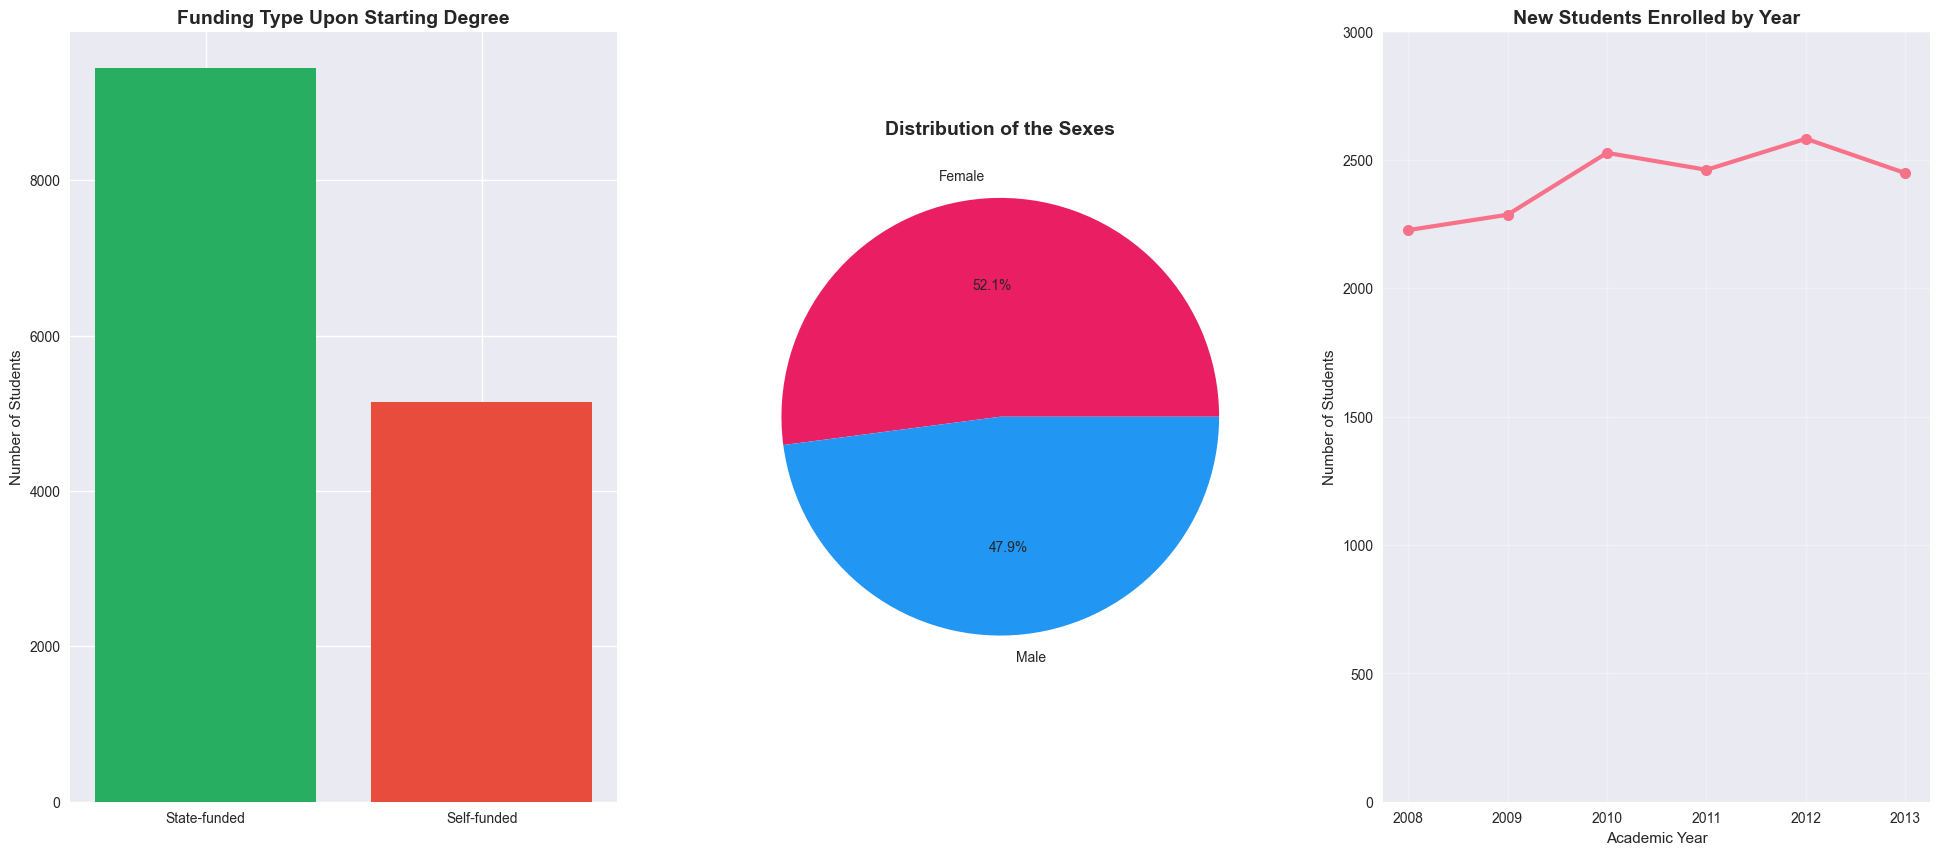

In [12]:
fig = plt.figure(figsize=(24, 10))

# Financial Status Distribution
plt.subplot(1, 3, 1)
funding_counts = df_analysis['is_state_funded'].value_counts()
plt.bar(range(len(funding_counts)), funding_counts.values, color=['#27ae60', '#e74c3c'])
plt.title('Funding Type Upon Starting Degree', fontsize=14, fontweight='bold')
plt.xticks(range(len(funding_counts)), ['State-funded\n', 'Self-funded'])
plt.ylabel('Number of Students')


plt.subplot(1, 3, 2)
gender_counts = df_analysis['gender'].value_counts()
plt.pie(gender_counts.values, labels=['Female', 'Male'], autopct='%1.1f%%', colors=['#e91e63', '#2196f3'])
plt.title('Distribution of the Sexes', fontsize=14, fontweight='bold')

# 6. Enrollment Trends Over Time
plt.subplot(1, 3, 3)
# Group by academic year and count unique students starting
df_analysis['start_year'] = pd.to_datetime(df_analysis['start_date']).dt.year
yearly_enrollment = df_analysis.groupby('start_year')['student_id'].nunique()
plt.plot(yearly_enrollment.index, yearly_enrollment.values, marker='o', linewidth=3, markersize=8)
plt.title('New Students Enrolled by Year', fontsize=14, fontweight='bold')
plt.xlabel('Academic Year')
plt.ylabel('Number of Students')
plt.ylim(0, 3000)
plt.grid(True, alpha=0.3)


Text(0, 0.5, 'Average GPA')

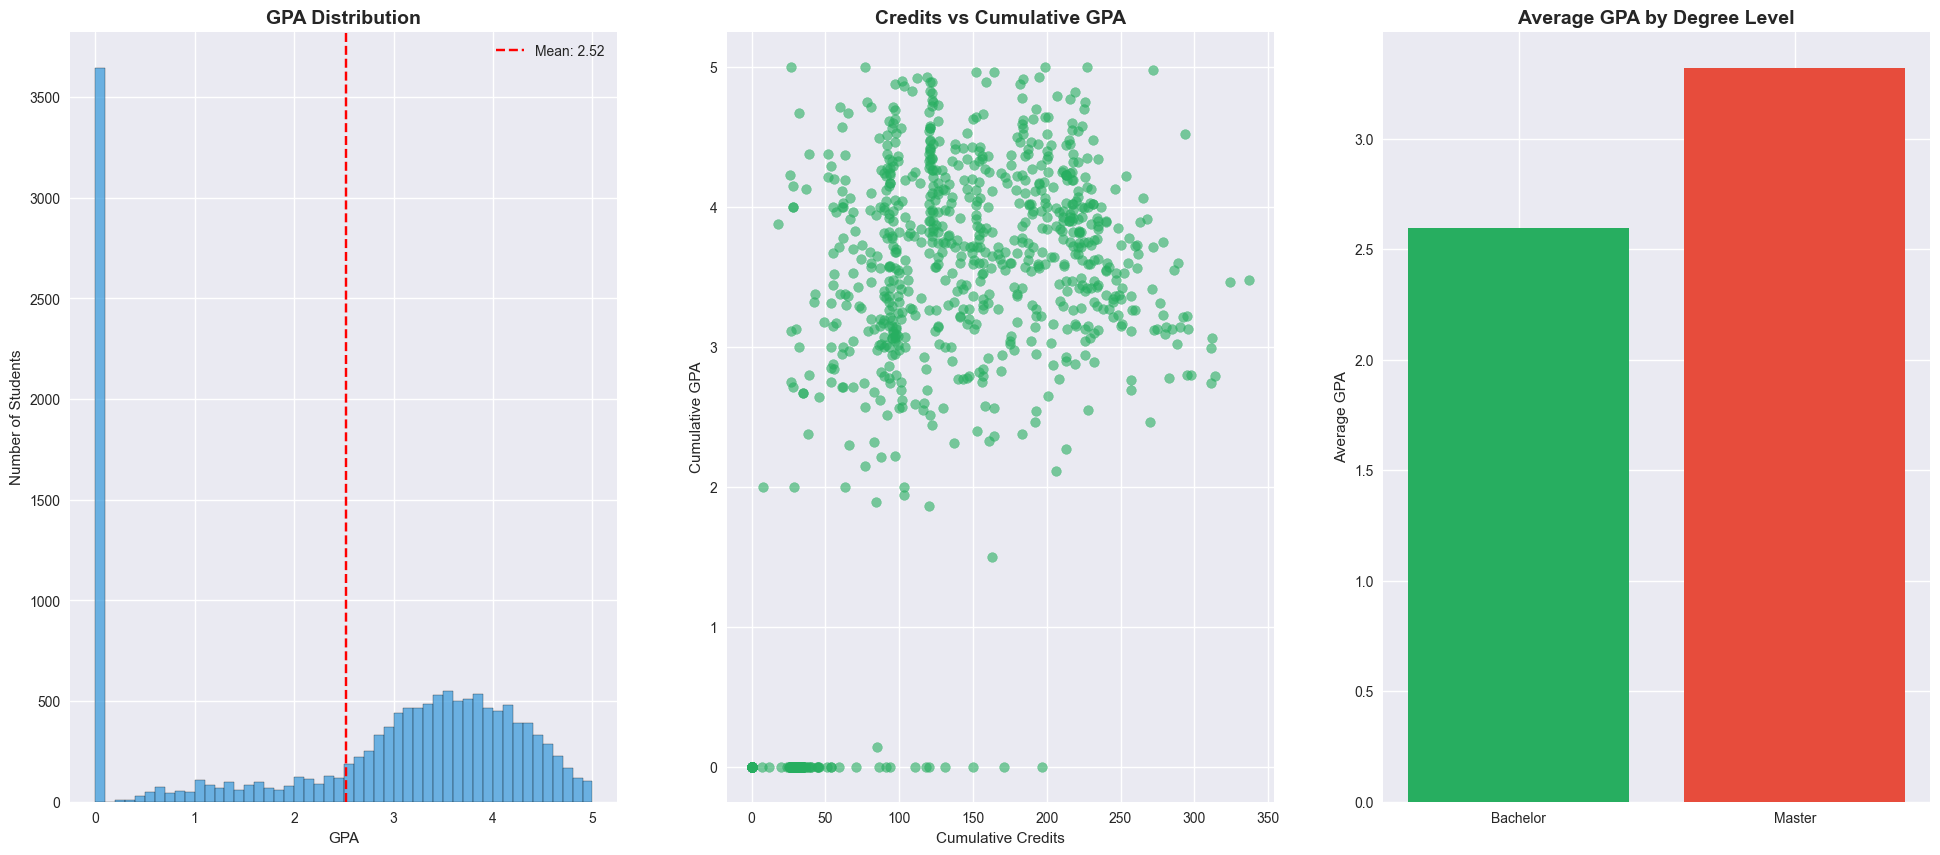

In [10]:
fig = plt.figure(figsize=(24, 10))

plt.subplot(1, 3, 1)
gpa_data = df_analysis['gpa'].dropna()
plt.hist(gpa_data, bins=50, alpha=0.7, color='#3498db', edgecolor='black')
plt.title('GPA Distribution', fontsize=14, fontweight='bold')
plt.xlabel('GPA')
plt.ylabel('Number of Students')
plt.axvline(gpa_data.mean(), color='red', linestyle='--', label=f'Mean: {gpa_data.mean():.2f}')
plt.legend()

plt.subplot(1, 3, 2)
sample_data = df_analysis.sample(n=min(1000, len(df_analysis))) 
plt.scatter(sample_data['cumulative_credits'], sample_data['cumulative_gpa'], alpha=0.6, color='#27ae60')
plt.title('Credits vs Cumulative GPA', fontsize=14, fontweight='bold')
plt.xlabel('Cumulative Credits')
plt.ylabel('Cumulative GPA')

plt.subplot(1, 3, 3)
program_performance = df_analysis.groupby('degree_level')['cumulative_gpa'].mean()
plt.bar(range(len(program_performance)), program_performance.values, color=['#27ae60', '#e74c3c'])
plt.title('Average GPA by Degree Level', fontsize=14, fontweight='bold')
plt.xticks(range(len(program_performance)), ['Bachelor', 'Master'])
plt.ylabel('Average GPA')


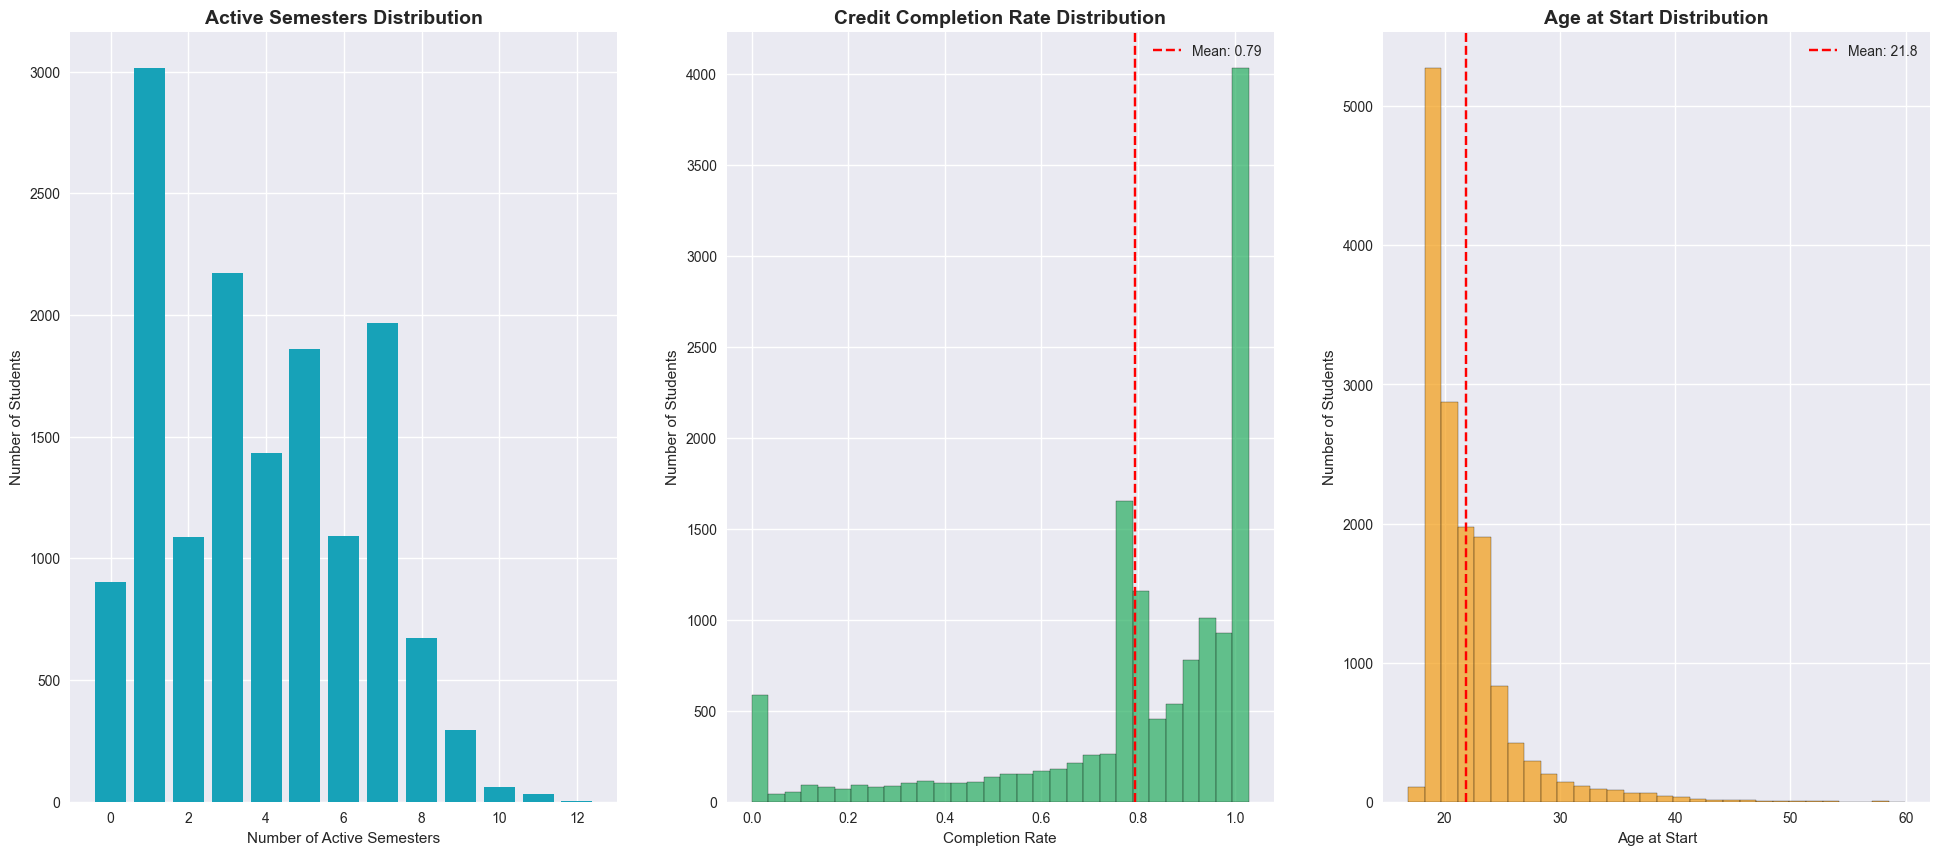

In [11]:
fig = plt.figure(figsize=(24, 10))
plt.subplot(1, 3, 1)
active_sem_counts = df_analysis['active_semesters'].value_counts().sort_index()
plt.bar(active_sem_counts.index, active_sem_counts.values, color='#17a2b8')
plt.title('Active Semesters Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Active Semesters')
plt.ylabel('Number of Students')

plt.subplot(1, 3, 2)
df_analysis['completion_rate'] = df_analysis['cumulative_completed'] / df_analysis['cumulative_credits']
completion_data = df_analysis['completion_rate'].dropna()
plt.hist(completion_data, bins=30, alpha=0.7, color='#27ae60', edgecolor='black')
plt.title('Credit Completion Rate Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Completion Rate')
plt.ylabel('Number of Students')
plt.axvline(completion_data.mean(), color='red', linestyle='--', label=f'Mean: {completion_data.mean():.2f}')
plt.legend()

plt.subplot(1, 3, 3)
df_analysis['age_at_start'] = (pd.to_datetime(df_analysis['start_date']) - pd.to_datetime(df_analysis['birth_date'])).dt.days / 365.25
age_data = df_analysis['age_at_start'].dropna()
plt.hist(age_data, bins=30, alpha=0.7, color='#f39c12', edgecolor='black')
plt.title('Age at Start Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Age at Start')
plt.ylabel('Number of Students')
plt.axvline(age_data.mean(), color='red', linestyle='--', label=f'Mean: {age_data.mean():.1f}')
plt.legend()

